In [2]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
DIRECTORY =r"D:\dataset"

In [4]:
CATEGORIES = ["with_mask", "without_mask"]

In [5]:
print("[INFO] loading images...")

[INFO] loading images...


In [6]:
data = []
labels = []

In [7]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)

C:\Users\HP\Anaconda3\envs\tf\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [8]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [10]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [11]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [12]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

C:\Users\HP\Anaconda3\envs\tf\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 40s 4us/step


In [13]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [14]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [15]:
for layer in baseModel.layers:
    layer.trainable = False

In [16]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [17]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] training head...
  ...
    to  
  ['...']
Train for 92 steps, validate on 739 samples
Epoch 1/20
92/92 [==============================] - 748s 8s/step - loss: 0.5445 - accuracy: 0.7182 - val_loss: 0.5993 - val_accuracy: 0.7092
Epoch 2/20
92/92 [==============================] - 803s 9s/step - loss: 0.3160 - accuracy: 0.8723 - val_loss: 0.4680 - val_accuracy: 0.8139
Epoch 3/20
92/92 [==============================] - 805s 9s/step - loss: 0.2447 - accuracy: 0.9065 - val_loss: 0.3929 - val_accuracy: 0.8505
Epoch 4/20
92/92 [==============================] - 776s 8s/step - loss: 0.2038 - accuracy: 0.9202 - val_loss: 0.4647 - val_accuracy: 0.8573
Epoch 5/20
92/92 [==============================] - 756s 8s/step - loss: 0.1736 - accuracy: 0.9360 - val_loss: 0.4795 - val_accuracy: 0.8560
Epoch 6/20
92/92 [==============================] - 787s 9s/step - loss: 0.1529 - accuracy: 0.9397 - val_loss: 0.3331 - val_accuracy: 0.8954
Epoch 7/20
92/92 [==============================] - 827s 9s/s

In [20]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [21]:
predIdxs = np.argmax(predIdxs, axis=1)

In [23]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


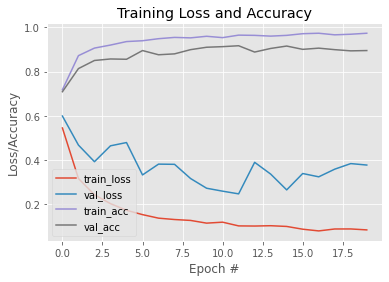

In [25]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")